### Introduction ###

There are four decoders included in the **replay_trajectory_classification** package:
+ `SortedSpikesDecoder`
+ `ClusterlessDecoder`
+ `SortedSpikesClassifier`
+ `ClusterlessClassifier`.

You can import them for use by running the following lines of code:

In [1]:
from replay_trajectory_classification import (SortedSpikesDecoder, ClusterlessDecoder,
                                              SortedSpikesClassifier, ClusterlessClassifier)

If `Decoder` is in the name it indicates that a single movement model is used to decode position.

If `Classifier` is in the name it means that multiple movement models are used to decode position and classify the type of movement.

`SortedSpikes` and `Clusterless` indicate the type of data the decoder uses:
+ `SortedSpikes` means the decoder takes in clustered single unit data.
+ `Clusterless` means the decoder takes in unsorted multiunit spikes and associated spike waveform features---like those that would usually be used to spike sort such as spike width, spike amplitude, etc.


Next, we will explore the expected data format for `SortedSpikes` and `Clusterless` decoders in turn. The both the `Decoder` and `Classifier` take the same data format.

### Sorted Spikes Data Format ###

We can see from the docstring of the fit function of `SortedSpikesDecoder` that there are two main variables that are required:
+ **position** - the 1D or 2D position of the animal at each time bin
+ **spikes** - 0 if there is no spike and 1 if there is a spike for each cell for each time bin

**NOTE**: Time bins should be small (typically 1 or 2 ms)

In [2]:
SortedSpikesDecoder.fit?

Signature:
SortedSpikesDecoder.fit(
    self,
    position,
    spikes,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : ndarray, shape (n_time, n_position_dims)
spikes : ndarray, shape (n_time, n_neurons)
is_training : None or bool ndarray, shape (n_time), optional
    Time bins to be used for encoding.
is_track_interior : None or bool ndaarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data #### 
Let's look at some simulated data to get an intuition for these data types. We simulate spikes of 19 cells with 360,000 time bins (360 seconds) of data:

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data

time, position, sampling_frequency, spikes, place_fields = make_simulated_run_data()

We can see that this numpy array is a matrix with time bins in the first dimension and cells on the second dimension

In [4]:
spikes.shape

(360000, 19)

and that there is a 1 each time a cell spikes and a 0 each time there is not a spike. For example, for the first cell, there is only one spike at 17 ms in the first 100 ms of time:

In [5]:
spikes[:100, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

We can visualize the spikes as a spike raster:

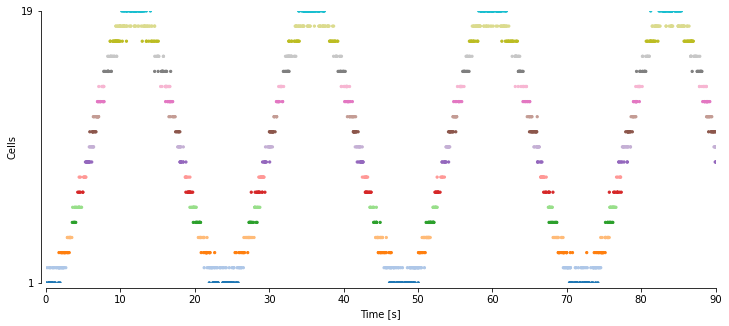

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5))
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

c = [cmap.colors[ind] for ind in neuron_ind]
ax.scatter(time[spike_ind], neuron_ind + 1, c=c, s=5)
ax.set_yticks((1, spikes.shape[1]))
ax.set_ylim((1, spikes.shape[1]))
ax.set_ylabel('Cells')

ax.set_xlabel('Time [s]')
ax.set_xlim((0.0, 90.0))
sns.despine(offset=5)

We also have a position variable which has the same number of time points and has one position dimension:

In [7]:
position.shape

(360000,)

We can plot position over time:

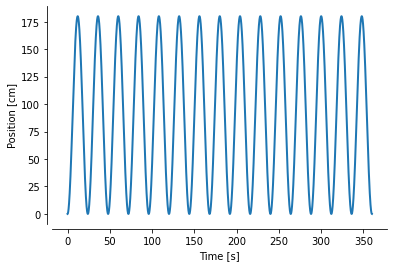

In [8]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(time, position, linewidth=2)
ax.set_ylabel("Position [cm]")
ax.set_xlabel("Time [s]")
sns.despine(offset=5)

#### Summary ####
So we have two numpy arrays that contain the data we need to fit and evaluate the model:

In [9]:
spikes.shape

(360000, 19)

In [10]:
position.shape

(360000,)

### Clusterless Data Format ###

The `Clusterless` decoders take the same information as the `SortedSpikes` decoders with one exception: the actual multiunit spikes and their associated waveform features. This variable is called **multiunits** and it has time bins on the first dimension, the marks (or associated wave form features) in the second dimension, and the electrodes in the last dimension.

In [11]:
ClusterlessDecoder.fit?

Signature:
ClusterlessDecoder.fit(
    self,
    position,
    multiunits,
    is_training=None,
    is_track_interior=None,
    track_graph=None,
    edge_order=None,
    edge_spacing=15,
)
Docstring:
Parameters
----------
position : array_like, shape (n_time, n_position_dims)
multiunits : array_like, shape (n_time, n_marks, n_electrodes)
is_training : None or array_like, shape (n_time,)
is_track_interior : None or ndarray, shape (n_x_bins, n_y_bins)
track_graph : networkx.Graph
edge_order : array_like
edge_spacing : None, float or array_like

Returns
-------
self
File:      ~/Documents/GitHub/replay_trajectory_classification/replay_trajectory_classification/decoder.py
Type:      function


#### Example Data ####

For the multiunits array, if there is no spike in a particular time bin, there are only NaNs. If there is a spike, then the values of the associated waveform feature are filled in. Let's loook at some example simulated data:

In [12]:
from replay_trajectory_classification.clusterless_simulation import make_simulated_run_data

(time, position, sampling_frequency,
 multiunits, _) = make_simulated_run_data()

We can see that there are 350,000 time bins, 4 mark dimensions (wave form features), and 5 electrodes:

In [13]:
multiunits.shape

(350000, 4, 5)

If we look at the first electrode, we see that there is a spike in the first time bin and then no spike for the next 9 time bins (hence they are filled with NaNs):

In [14]:
multiunits[:10, :, 0]

array([[        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan],
       [ 0.4660213 , -0.6409163 , -1.76878907, -1.10763897]])

These four values represent waveform features of this electrode at the time of the spike. Likewise, if we look at the second electrode, we can see that there was no spike in the first 10 time bins.

In [15]:
multiunits[:10, :, 1]

array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]])

### Track Graph ###

If you are using 1D position but want to represent an environment more complicated than a linear track, you need to constract a graph representation of the track that indicates how the 1D position can connect. We refer to this as the **track_graph**. This is done using the NetworkX package.

Now we define the x- and y-position of the nodes. The nodes are automatically named by their order:
+ node "0" has position (0, 0)
+ node "1" has position (1, 0)
+ node "2" has position (1, 1)
+ node "3" has position (0, 1)

In [16]:
node_positions = [(0, 0), # xy position of node 0
                  (1, 0), # xy position of node 1
                  (1, 1), # xy position of node 2
                  (0, 1), # xy position of node 3
                 ]

Then we can define how the nodes are connected by their node names. So if we want node "0" and node "1" to be connected, then we specify (0, 1)

In [17]:
edges = [(0, 1), # connects node 0 and node 1
         (1, 2), # connects node 1 and node 2
         (2, 3), # connects node 2 and node 3
        ]

Then we can construct a graph of the track by using the function `make_track_graph`, which will return a NetworkX Graph object:

In [18]:
from replay_trajectory_classification import make_track_graph


track_graph = make_track_graph(node_positions, edges)

track_graph

In [19]:
track_graph.nodes

NodeView((0, 1, 2, 3))

In [20]:
track_graph.edges

EdgeView([(0, 1), (1, 2), (2, 3)])

We can visualize the **track_graph** by using our `plot_track_graph` function:

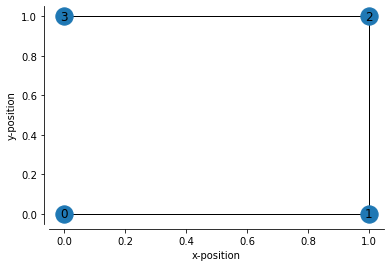

In [21]:
from replay_trajectory_classification import plot_track_graph

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

We can change how these points are connected by changing the edges:

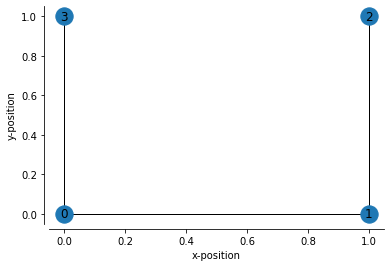

In [22]:
edges = [(0, 1), # connects node 0 and node 1
         (0, 3), # connects node 0 and node 3
         (1, 2), # connects node 1 and node 2
        ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

We could also change the node positions:

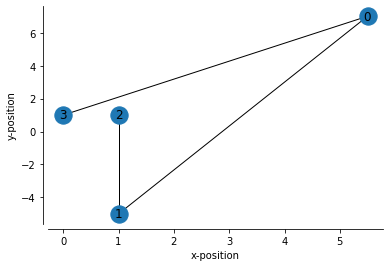

In [23]:
node_positions = [(5.5, 7), # xy position of node 0
                  (1, -5), # xy position of node 1
                  (1, 1), # xy position of node 2
                  (0, 1), # xy position of node 3
                 ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

There are two other parameters when using `track_graph` with the decoders. These specify how the edges correspond to 1D position:
+ **edge_order** -- The order of the edges in 1D position in terms of their node pairs e.g. (0, 1) represents the edge connecting node 0 to node 1.
+ **edge_spacing** -- The spacing between the edges. This is necessary when edges are not connected to each other in 2D space, because the smoothing used by the model will inappropriately smooth into a non-adjacent edge. This will always be one less than the number of edges.


For example, we might linearize the above track by doing the following by specifying the following edge order and spacing:

In [24]:
edge_order = [(2, 1), # node 2 to node 1
              (1, 0), # node 1 to node 0
              (0, 3), # node 0 to node 3
              ]
edge_spacing = 0 # no spacing between edges

We can visualize the linearization layout by using `plot_graph_as_1D`:

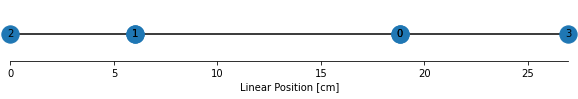

In [25]:
from replay_trajectory_classification import plot_graph_as_1D

fig, ax = plt.subplots(figsize=(10, 1))
plot_graph_as_1D(track_graph, edge_order, edge_spacing,
                 ax=ax)

If we wanted, we could put spaces between each edge. For example if we want 5 cm spaces between edges:

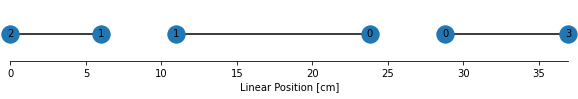

In [26]:
edge_order = [(2, 1), # node 2 to node 1
              (1, 0), # node 1 to node 0
              (0, 3), # node 0 to node 3
              ]
edge_spacing = 5

fig, ax = plt.subplots(figsize=(10, 1))
plot_graph_as_1D(track_graph, edge_order, edge_spacing,
                 ax=ax)

We can also change the spacing by depending on the edges:

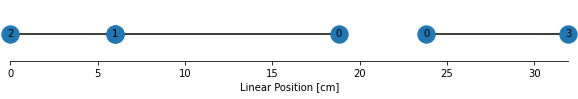

In [27]:
edge_order = [(2, 1), # node 2 to node 1
              (1, 0), # node 1 to node 0
              (0, 3), # node 0 to node 3
              ]
edge_spacing = [0, 5]

fig, ax = plt.subplots(figsize=(10, 1))
plot_graph_as_1D(track_graph, edge_order, edge_spacing,
                 ax=ax)

Now let's try a more complicated track, where you should put spacing in between edges:

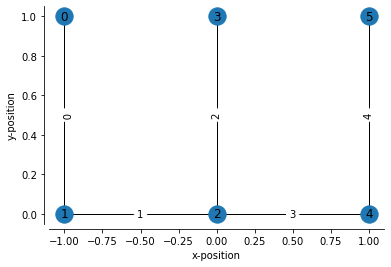

In [28]:
node_positions = [(-1, 1), # xy position of node 0
                  (-1, 0), # xy position of node 1
                  (0, 0), # xy position of node 2 *
                  (0, 1), # xy position of node 3
                  (1, 0), # xy position of node 4
                  (1, 1), # xy position of node 5
                 ]

edges = [(0, 1), # connects node 0 and node 1
         (1, 2), # connects node 1 and node 2
         (2, 3), # connects node 2 and node 3
         (2, 4), # connects node 2 and node 4
         (4, 5), # connects node 4 and node 5
        ]

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots()
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

In this case, the edge 2 (between nodes 2 and 3) has to be placed separately from the other edges in 1D position, so a gap is needed. One possible scheme would be:

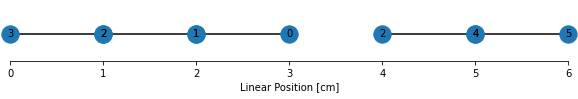

In [29]:
center_well_id = 3
edge_order = [(3, 2),
              (2, 1),
              (1, 0),
              (2, 4),
              (4, 5)
             ]
edge_spacing = [0, 0, 1, 0]

fig, ax = plt.subplots(figsize=(10, 1))
plot_graph_as_1D(track_graph, edge_order, edge_spacing,
                 ax=ax)

The edge spacing is 0 between edges 2 and edges 1 because they are connected. Likewise the edge spacing is 0 between edges 1 and 0 because they are connected.

**Importantly**, the edge spacing between edges 0 and 3 is 1 because edge 0 and 3 are not directly connected and we don't want to smooth positions on edge 0 onto edge 3. Note that this depends on the size of your bandwidth (for the `Clusterless` decoder) or the knot spacing (for the `SortedSpikesDecoder`).

Finally let's try a track shaped like a circle.

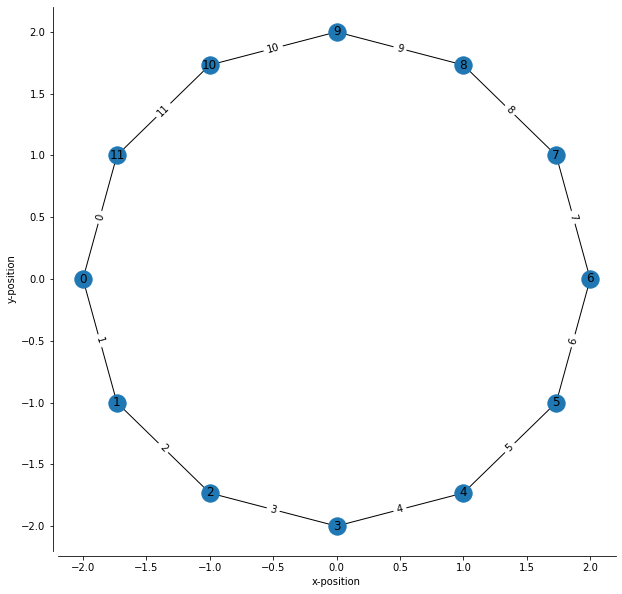

In [30]:
angle = np.linspace(-np.pi, np.pi, num=12, endpoint=False)
radius = 2

node_positions = np.stack((radius * np.cos(angle), radius * np.sin(angle)), axis=1)

node_ids = np.arange(node_positions.shape[0])
edges = np.stack((node_ids, np.roll(node_ids, shift=1)), axis=1)

track_graph = make_track_graph(node_positions, edges)

fig, ax = plt.subplots(figsize=(10, 10))
plot_track_graph(track_graph, ax=ax, draw_edge_labels=True)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position")
ax.set_ylabel("y-position")
sns.despine(offset=5)

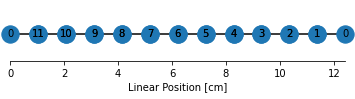

In [31]:
edge_spacing = 0
n_nodes = len(track_graph.nodes)
edge_order = np.stack((np.roll(np.arange(n_nodes-1, -1, -1), 1),
                       np.arange(n_nodes-1, -1, -1)), axis=1)

fig, ax = plt.subplots(figsize=(n_nodes // 2, 1))
plot_graph_as_1D(track_graph,
                 edge_spacing=edge_spacing,
                 edge_order=edge_order,
                 ax=ax)

In [32]:
edge_order

array([[ 0, 11],
       [11, 10],
       [10,  9],
       [ 9,  8],
       [ 8,  7],
       [ 7,  6],
       [ 6,  5],
       [ 5,  4],
       [ 4,  3],
       [ 3,  2],
       [ 2,  1],
       [ 1,  0]])